In [7]:
import copy
import os
import re

from matplotlib import pyplot as plt
import textgrids
from scipy.io import wavfile
from silence_aligner import extract_segments_from_file
import IPython.display
from jiwer import wer

In [8]:

length_std = {'sil': 0.37004250783970655,
 'g': 0.0970459455376011,
 'a': 0.05660433687030533,
 'f': 0.056929615415985,
 's': 0.10598433935792115,
 'n': 0.044217450983390603,
 'r': 0.025405123070675686,
 'j': 0.06591924956009611,
 'R': 0.0517020847447505,
 'o': 0.060734759874077476,
 'b': 0.06107722854276204,
 'i': 0.04044209198174864,
 'k': 0.09041679558761224,
 'u': 0.050785248251638125,
 'd': 0.053657157384060246,
 'e': 0.04168302088249228,
 'l': 0.05306956815151603,
 'c': 0.08385220938537917,
 'm': 0.05156874573425406,
 't': 0.05078924791058343,
 'p': 0.06496014058103297,
 'y': 0.004456240066948667,
 'C': 0.024831451374519697,
 'N': 0.0,
 '': 0.646766174211673,
 'S': 0.0}

length_avg = {'sil': 0.6619947347517942,
 'g': 0.10168757313538922,
 'a': 0.14216359277803084,
 'f': 0.12765944865075077,
 's': 0.1842492552669475,
 'n': 0.10900618568216998,
 'r': 0.04598977151391705,
 'j': 0.1038708272358285,
 'R': 0.09990348885317477,
 'o': 0.14870062878468995,
 'b': 0.08269588485554184,
 'i': 0.1294199589781047,
 'k': 0.11736411443279583,
 'u': 0.14413120538869068,
 'd': 0.08530152426467356,
 'e': 0.11940625321237626,
 'l': 0.11286410173154132,
 'c': 0.10325003239861755,
 'm': 0.11838473491333955,
 't': 0.07873005754645007,
 'p': 0.06925395812614847,
 'y': 0.11183312549768909,
 'C': 0.12745184747265748,
 'N': 0.05756467874794069,
 '': 0.49404709249643247,
 'S': 0.09273662429796059}

In [9]:
AUDIOS_FOLDER = "cropped_audios"
TRANSCRIPTION_FOLDER = "cropped_annotations"
TEXTS_FOLDER = "texts"
OUTPUT_ALIGN_FOLDER = "phoneme_length_align"

In [180]:
base_file_name = "M_74_1"
os.getcwd()

'/home/ma0/projects/openspeechorg/python-speech-soa/06_alignment'

In [181]:
frequency_from_signal, signal = wavfile.read(
    os.path.join(
        AUDIOS_FOLDER,
        f"cropped_{base_file_name}.wav"
    )
)
# plt.plot(signal)

In [182]:
IPython.display.Audio(signal, rate=frequency_from_signal)

In [183]:
silences, frequency  = extract_segments_from_file(
    os.path.join(
        AUDIOS_FOLDER,
        f"cropped_{base_file_name}.wav",
    ),
)

Desired threshold, 0.05
2125183467.5488214


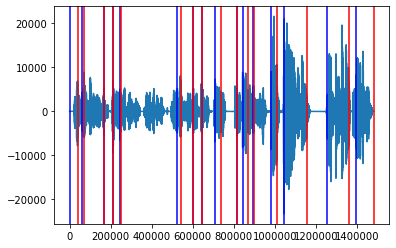

In [184]:
segments = list()
last_start = 0
for start, stop in silences:
    segments.append((last_start, start))
    last_start = stop

segments.append((last_start,signal.shape[-1]))
plt.plot(signal)
for start, stop in segments:
    plt.axvline(start, color="blue")
    plt.axvline(stop, color="red")

In [185]:
def sent_tokenize(text):
    return [x for x in re.split("\.|,|;|:|\n|!|¿|¡|\?|-|—|\(|\)|«|»", text) if x.replace(" ", "")]

with open(
    os.path.join(
        TEXTS_FOLDER,
        f"{base_file_name.replace('cropped_', '')}.txt"
    )) as file:
    text = " ".join(file.readlines())

tokens = sent_tokenize(text)
tokens = tokens[1:]
words_count = len(text.split(" "))

In [186]:
# tokens

In [187]:
signal_segment_lengths = [(stop-start)/frequency for start, stop in segments]

In [188]:

sum(signal_segment_lengths)

10.73986394557823

In [152]:
remap = {
    "z": "s",
    "v": "b",
    "q": "k",
    "ñ": "N",
    "h": "",
    "ó": "o",
    "á": "a",
    "é": "e",
    "í": "i",
    "ú": "u",
    "x": "s",
    "♥": ""
}

def calculate_token_lengths(text):
    partial_times = list()
    partial_std = list()
    for letter in text:
        letter = remap.get(letter, letter).strip().lower()
        if letter in length_avg:
            partial_times.append(length_avg[letter])
            partial_std.append(length_std[letter])
        else:
            print(f"Letter not found {letter}")
    return sum(partial_times), sum(partial_std)

expected_token_lengths = [calculate_token_lengths(text) for text in tokens]

In [153]:
sum([x[0] for x in expected_token_lengths])

70.08294399459844

In [154]:

len(expected_token_lengths)

6

In [155]:

len(signal_segment_lengths)

12

In [156]:
len(tokens)

6

In [157]:
def safe_access(arr, i):
    return arr[i] if i < len(arr) else ""

for i in range(max(len(expected_token_lengths), len(signal_segment_lengths), len(tokens))):
    print(safe_access(tokens, i), safe_access(signal_segment_lengths, i), safe_access(expected_token_lengths, i))


 Se introdujo una comadreja en el taller de un herrero y se puso a lamer una lima que ahí se encontraba 2.06 (20.69933157567825, 19.021142424008175)
 Al cabo de un rato su lengua arrojaba sangre en abundancia 1.45 (11.071378930847471, 9.783678890957232)
 y la comadreja se puso muy feliz pensando que había arrancado algo al hierro 3.96 (15.237894751170005, 13.697023774872482)
 hasta que acabó por perder su propia lengua 1.0 (8.40531876662517, 7.8098111258213345)
 Piensa siempre que si haces un daño 1.23 (7.473935372753761, 6.827399063745265)
 tarde o temprano éste regresará contra tí 0.92 (7.1950845975237705, 6.3409941580140945)
 2.17 
 2.88 
 2.97 
 2.12 
 1.0 
 2.6030385487528345 


In [158]:

EXPECTED_TOKEN_LENGTH = expected_token_lengths
# EXPECTED_TOKEN_LENGTH = [(1,0), (1,0), (1,0), (2,0)]
EXPECTED_TOKEN_LENGTH

[(20.69933157567825, 19.021142424008175),
 (11.071378930847471, 9.783678890957232),
 (15.237894751170005, 13.697023774872482),
 (8.40531876662517, 7.8098111258213345),
 (7.473935372753761, 6.827399063745265),
 (7.1950845975237705, 6.3409941580140945)]

In [159]:
len(EXPECTED_TOKEN_LENGTH)

6

In [160]:
SIGNAL_SEGMENT_LENGTHS = signal_segment_lengths
# SIGNAL_SEGMENT_LENGTHS = [1,2,1,1]
signal_segment_lengths

[2.06,
 1.45,
 3.96,
 1.0,
 1.23,
 0.92,
 2.17,
 2.88,
 2.97,
 2.12,
 1.0,
 2.6030385487528345]

In [161]:
len(SIGNAL_SEGMENT_LENGTHS)

12

In [162]:
expected_signal_ratio = sum([x[0] for x in EXPECTED_TOKEN_LENGTH]) / sum(SIGNAL_SEGMENT_LENGTHS)
expected_signal_ratio

2.876609329922275

In [163]:
evaluation_stack = [(list(), 0, 0)]

In [164]:
def evaluate_experiment(current_result, expected_index, segment_index, debug=False):
    while expected_index < len(EXPECTED_TOKEN_LENGTH) and segment_index < len(SIGNAL_SEGMENT_LENGTHS):
        expected_avg, expected_std = EXPECTED_TOKEN_LENGTH[expected_index]
        expected_avg = expected_avg / expected_signal_ratio
        expected_std =  0 * expected_std
        segment_length = SIGNAL_SEGMENT_LENGTHS[segment_index]
        if expected_avg - expected_std <= segment_length <= expected_avg + expected_std:
            if debug:
                print("Segment in range expected")
            current_result.append([[expected_index], [segment_index]])
            expected_index += 1
            segment_index += 1
        elif segment_length < expected_avg - expected_std:
            if debug:
                print("Segment too short")
                print(segment_length, expected_avg - expected_std)
            cum_length = segment_length
            cum_index = [segment_index]
            segment_index += 1
            while cum_length < expected_avg - expected_std and segment_index < len(SIGNAL_SEGMENT_LENGTHS):
                if debug:
                    print("Appending", expected_index + 1, segment_index )
                copy_current_result = copy.deepcopy(current_result)
                copy_current_result.append([[expected_index], [segment_index - 1]])
                evaluation_stack.append((copy_current_result, expected_index + 1, segment_index ))
                cum_length += SIGNAL_SEGMENT_LENGTHS[segment_index]
                cum_index.append(segment_index)
                segment_index += 1
            current_result.append([[expected_index], cum_index])
            expected_index += 1
        else:
            if debug:
                print("Segment too long")
                print(segment_length, expected_avg - expected_std)
            cum_length = expected_avg
            cum_index = [expected_index]
            expected_index += 1
            while cum_length < segment_length and expected_index < len(EXPECTED_TOKEN_LENGTH):
                if debug:
                    print("Appending", expected_index, segment_index + 1)
                copy_current_result = copy.deepcopy(current_result)
                copy_current_result.append([[expected_index - 1], [segment_index]])
                evaluation_stack.append((copy_current_result, expected_index, segment_index + 1))
                cum_length += EXPECTED_TOKEN_LENGTH[expected_index][0]
                cum_index.append(expected_index)
                expected_index += 1
            current_result.append([cum_index, [segment_index]])
            segment_index += 1
    return current_result

# result = evaluate_experiment(list(), 0, 0)

In [165]:
possible_results = list()

MAX_ITERS = 10000
i = 0
while evaluation_stack and i<MAX_ITERS:
    i += 1
    # print("SIZE OF THE STACK", len(evaluation_stack))
    current_experiment = evaluation_stack.pop(0)
    # print(current_experiment[0][-1] if len(current_experiment[0]) > 1 else current_experiment[0], current_experiment[1], current_experiment[2])
    possible_results.append(evaluate_experiment(current_experiment[0], current_experiment[1], current_experiment[2]))

print("Final i", i)


Final i 135


In [166]:
def evaluate_result(result_array):
    # return (len(EXPECTED_TOKEN_LENGTH) - 1 - result_array[-1][0][-1]) + (len(SIGNAL_SEGMENT_LENGTHS) - 1 - result_array[-1][1][-1])
    partial_results = 0
    for calculated_segment_length_list, actual_segment_length_list in result_array:
        partial_results += abs(
            sum(EXPECTED_TOKEN_LENGTH[x][0]/expected_signal_ratio for x in calculated_segment_length_list) -
            sum(SIGNAL_SEGMENT_LENGTHS[x] for x in actual_segment_length_list)
        )
    return partial_results

def evaluate_all_results(possible_results):
    return_list = list()
    for index, result_list in enumerate(possible_results):
        return_list.append((index, evaluate_result(result_list)))
    return return_list
evaluation_results = evaluate_all_results(possible_results)
min(evaluation_results, key=lambda x: x[1])

(8, 2.5012380105567544)

In [167]:
all_min_values = list(filter(lambda x: x[1] == min(evaluation_results, key=lambda x: x[1])[1], evaluation_results))
all_min_values

[(8, 2.5012380105567544)]

In [168]:
for min_value in all_min_values:
    print(possible_results[min_value[0]])
    print("-----")

[[[0], [0, 1, 2]], [[1], [3, 4, 5, 6]], [[2], [7, 8]], [[3], [9, 10]], [[4], [11]]]
-----


In [169]:
first_min_value = all_min_values[0]
first_min_value

(8, 2.5012380105567544)

In [170]:
first_min_value_index = first_min_value[0]
first_min_value_index

8

In [171]:
min_value_selected = possible_results[first_min_value_index]
min_value_selected

[[[0], [0, 1, 2]],
 [[1], [3, 4, 5, 6]],
 [[2], [7, 8]],
 [[3], [9, 10]],
 [[4], [11]]]

In [172]:

alignment = list()


for calculated_segment_length_list, actual_segment_length_list in min_value_selected:
    print(actual_segment_length_list)
    alignment.append(
        {
            "text": ' '.join([tokens[x] for x in calculated_segment_length_list]),
            "xmin":  segments[actual_segment_length_list[0]][0]/frequency,
            "xmax":  segments[actual_segment_length_list[-1]][1]/frequency

        }
    )

alignment

[0, 1, 2]
[3, 4, 5, 6]
[7, 8]
[9, 10]
[11]


[{'text': ' Se introdujo una comadreja en el taller de un herrero y se puso a lamer una lima que ahí se encontraba',
  'xmin': 0.0,
  'xmax': 9.02},
 {'text': ' Al cabo de un rato su lengua arrojaba sangre en abundancia',
  'xmin': 10.28,
  'xmax': 17.84},
 {'text': ' y la comadreja se puso muy feliz pensando que había arrancado algo al hierro',
  'xmin': 18.57,
  'xmax': 25.34},
 {'text': ' hasta que acabó por perder su propia lengua',
  'xmin': 27.24,
  'xmax': 31.17},
 {'text': ' Piensa siempre que si haces un daño',
  'xmin': 31.77,
  'xmax': 34.37303854875283}]

In [173]:
min_value_selected

[[[0], [0, 1, 2]],
 [[1], [3, 4, 5, 6]],
 [[2], [7, 8]],
 [[3], [9, 10]],
 [[4], [11]]]

In [174]:

tg = textgrids.TextGrid()
tg.xmin = 0
tg.xmax = silences[-1][1] / frequency
tier = textgrids.Tier()
tg[base_file_name] = tier

for align in alignment:
    tier.append(
        textgrids.Interval(
            align["text"],
            align["xmin"],
            align["xmax"]
        )
    )

tg.write(
    os.path.join(
            OUTPUT_ALIGN_FOLDER,
            f"{base_file_name}_generated_phoneme_length.TextGrid"
        )
)

In [175]:

transcription_from_annotated_recording = textgrids.TextGrid(
    os.path.join(
        TRANSCRIPTION_FOLDER,
        f"cropped_{base_file_name}.TextGrid"
    )
)

intervals_from_annotated_recording = transcription_from_annotated_recording[base_file_name.replace("cropped_", "")]

In [176]:

wer_list = list()

current_annotation_index = 0
current_interval_index = 0
while current_interval_index < len(intervals_from_annotated_recording):
    try:
        interval = intervals_from_annotated_recording[current_interval_index]
        t_text = interval.text
        t_min = interval.xmin
        t_max = interval.xmax

        a_text = alignment[current_annotation_index]["text"]
        a_min = alignment[current_annotation_index]["xmin"]
        a_xmax = alignment[current_annotation_index]["xmax"]

        if a_xmax < t_max + 1:
            print("Match: ", a_xmax, t_max + 1,)
            try:
                wer_list.append((tokens[int(t_text)-1], a_text))
            except ValueError:
                print("Skipping last??")
        else:
            print("Not Match", a_xmax, t_max + 1,)
            interval_to_append = [t_text]

            while not a_xmax < t_max + 1:
                print("trying next", a_xmax, t_max + 0.5)
                current_interval_index += 1
                interval = intervals_from_annotated_recording[current_interval_index]
                t_text = interval.text
                t_min = interval.xmin
                t_max = interval.xmax
                interval_to_append.append(t_text)
            value_to_append = list()
            for i in interval_to_append:
                try:
                    value_to_append.append(tokens[int(i)-1])
                except ValueError:
                    print("Error decoding", i)
            wer_list.append(("".join(value_to_append), a_text))


        current_interval_index += 1
        current_annotation_index += 1
    except IndexError:
        print("Exiting on index current_interval_index", current_interval_index, "current_annotation_index", current_annotation_index)
        break

Match:  9.02 10.719773242630389
Not Match 17.84 16.205898674266365
trying next 17.84 15.705898674266365
Match:  25.34 27.03362811791383
Not Match 31.17 30.920430839002265
trying next 31.17 30.420430839002265


In [177]:
wer_list

[(' Se introdujo una comadreja en el taller de un herrero y se puso a lamer una lima que ahí se encontraba',
  ' Se introdujo una comadreja en el taller de un herrero y se puso a lamer una lima que ahí se encontraba'),
 (' Al cabo de un rato su lengua arrojaba sangre en abundancia y la comadreja se puso muy feliz pensando que había arrancado algo al hierro',
  ' Al cabo de un rato su lengua arrojaba sangre en abundancia'),
 (' hasta que acabó por perder su propia lengua',
  ' y la comadreja se puso muy feliz pensando que había arrancado algo al hierro'),
 (' Piensa siempre que si haces un daño tarde o temprano éste regresará contra tí',
  ' hasta que acabó por perder su propia lengua')]

In [178]:

wer_values = list()
for x in wer_list:
    true_value = x[0].split()
    inferred_value = x[1].split()
    local_wer = wer(true_value, inferred_value)
    percentaje = len(true_value)/ words_count
    print(true_value)
    print(inferred_value)
    print(local_wer)
    print(percentaje)
    wer_values.append(local_wer * percentaje)

wer_values

['Se', 'introdujo', 'una', 'comadreja', 'en', 'el', 'taller', 'de', 'un', 'herrero', 'y', 'se', 'puso', 'a', 'lamer', 'una', 'lima', 'que', 'ahí', 'se', 'encontraba']
['Se', 'introdujo', 'una', 'comadreja', 'en', 'el', 'taller', 'de', 'un', 'herrero', 'y', 'se', 'puso', 'a', 'lamer', 'una', 'lima', 'que', 'ahí', 'se', 'encontraba']
0.0
0.27631578947368424
['Al', 'cabo', 'de', 'un', 'rato', 'su', 'lengua', 'arrojaba', 'sangre', 'en', 'abundancia', 'y', 'la', 'comadreja', 'se', 'puso', 'muy', 'feliz', 'pensando', 'que', 'había', 'arrancado', 'algo', 'al', 'hierro']
['Al', 'cabo', 'de', 'un', 'rato', 'su', 'lengua', 'arrojaba', 'sangre', 'en', 'abundancia']
0.56
0.32894736842105265
['hasta', 'que', 'acabó', 'por', 'perder', 'su', 'propia', 'lengua']
['y', 'la', 'comadreja', 'se', 'puso', 'muy', 'feliz', 'pensando', 'que', 'había', 'arrancado', 'algo', 'al', 'hierro']
1.75
0.10526315789473684
['Piensa', 'siempre', 'que', 'si', 'haces', 'un', 'daño', 'tarde', 'o', 'temprano', 'éste', 'regre

[0.0, 0.1842105263157895, 0.18421052631578946, 0.17105263157894737]

In [179]:
total_wer = sum(wer_values)
total_wer * 100

53.94736842105263

# UNUSED BELOW


In [ ]:
tg = textgrids.TextGrid()
tg.xmin = 0
tg.xmax = silences[-1][1] / frequency
tier = textgrids.Tier()
tg[base_file_name] = tier

index_time = 0
index_text = 0
time = 0

annotation = ""
time_index = 0
for i, (expected_time, std) in enumerate(expected_token_lengths):
    try:
        if expected_time - std < signal_segment_lengths[time_index] < expected_time + std:
            # Correspondencia
            print("First one")
            tier.append(
                    textgrids.Interval(
                        tokens[i],
                        segments[time_index][0]/frequency,
                        segments[time_index][1]/frequency
                    )
                )
            time_index += 1
            time += signal_segment_lengths[time_index]
        elif expected_time - std >  signal_segment_lengths[time_index]:
            print("Second one")
            # Misma anotacion multiples segmentos
            accum_time = signal_segment_lengths[time_index]
            start_index = time_index
            while expected_time - std > accum_time:
                time_index += 1
                accum_time += signal_segment_lengths[time_index]
            end_index = time_index
            tier.append(
                    textgrids.Interval(
                        tokens[i],
                        segments[start_index][0]/frequency,
                        segments[end_index][1]/frequency
                    )
                )
            time += accum_time
            print(time_index)
    except IndexError:
        print("O'o nos pasamos")
        break
tg.write(f"{base_file_name}_generated.TextGrid")

In [ ]:
enum = enumerate(expected_token_lengths)
time_index = 0

In [ ]:
i, (expected_time, std) = next(enum)
std = std / 2

In [ ]:
start = int(segments[time_index][0])
stop = int(segments[time_index][1])
wave = signal[start: stop]

IPython.display.Audio(wave, rate=frequency)


In [ ]:
plt.plot(signal)

plt.axvline(start, color="blue")
plt.axvline(stop, color="red")

In [ ]:
tokens[i]


In [ ]:
expected_time - std < signal_segment_lengths[time_index] < expected_time + std

In [ ]:
print(expected_time)
print(std)
print(signal_segment_lengths[time_index])
expected_time - std

In [ ]:

if expected_time - std < signal_segment_lengths[time_index] < expected_time + std:
    # Correspondencia
    print("First one")
    tier.append(
            textgrids.Interval(
                tokens[i],
                segments[time_index][0]/frequency,
                segments[time_index][1]/frequency
            )
        )
    time_index += 1
    time += signal_segment_lengths[time_index]
elif expected_time - std >  signal_segment_lengths[time_index]:
    print("Second one")
    # Misma anotacion multiples segmentos
    accum_time = signal_segment_lengths[time_index]
    start_index = time_index
    while expected_time - std > accum_time:
        time_index += 1
        accum_time += signal_segment_lengths[time_index]
    end_index = time_index
    tier.append(
            textgrids.Interval(
                tokens[i],
                segments[start_index][0]/frequency,
                segments[end_index][1]/frequency
            )
        )
    time += accum_time
    print(time_index)